# Task

**1.** Создать CVAE

**2.** Подать 5 раз в decoder CVAE один и тот же случайный вектор и любой label от 0 до 9 на выбор. 



In [ ]:
!pip install keras==2.0 -q # загружаем эту версию кераса для корректной работы скрипта
!pip install tensorflow==1.13.0rc1 -q -q  # загружаем эту версию тензорфлоу  для корректной работы скрипта

     |████████████████████████████████| 194kB 5.1MB/s 
     |████████████████████████████████| 92.7MB 41kB/s 
     |████████████████████████████████| 368kB 38.3MB/s 
     |████████████████████████████████| 3.1MB 18.1MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.13.0rc1 which is incompatible.


In [ ]:
import sys # модуль содержит параметры и функции, которые относятся к Python и его среде
import numpy as np # загружаем библиотеку для работы с массивами данных
import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
%matplotlib inline
from scipy.stats import norm # модуль с нормальными непрерывными случайными величинами
# import seaborn as sns

from tensorflow.keras.datasets import mnist # загружаем готовую стандартную базу рукописных цифр mnist
from tensorflow.keras.utils import to_categorical # загружаем утилиты кераса для one-hot кодировки
from tensorflow.keras.layers import Input, Dense # загружаем необходимые слои(входной, полносвязный)
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda # загружаем слои(нормализации, регуляризации и т.д)
from tensorflow.keras.layers import concatenate, LeakyReLU # подгружаем слой конкатенации
from tensorflow.keras.models import Model # загружаем абстрактный класс базовой модели сети от кераса 
from tensorflow.keras.losses import binary_crossentropy # импортируем функцию потерь # импортируем функцию потерь
from tensorflow.keras import backend as K # устанавливаем переменную для окружения кераса
from tensorflow.keras.optimizers import Adam, RMSprop # загружаем выбранные оптимизаторы
from IPython.display import clear_output # импортируем модуль очистки output'а ячейки
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard # импортируем коллбэки

# Preprocessing

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() # загружаем данные из базы mnist с разбивкой на train/test
#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255. # представляем x_train в виде значений от 0 до 1
x_test  = x_test .astype('float32') / 255. # представляем x_test в виде значений от 0 до 1
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) # меняем форму, приводим к нужным нам размерам
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) # меняем форму, приводим к нужным нам размерам

y_train_cat = to_categorical(y_train, 10).astype(np.float32) # переводим обучающие лейблы в one-hot кодировку
y_test_cat  = to_categorical(y_test, 10).astype(np.float32)# переводим проверочные лейблы в one-hot кодировку
num_classes = y_test_cat.shape[1] # задаем количество классов

# Modelling

In [ ]:
batch_size = 500 # размер батча УМЕНЬШЕНО С 500 ДО 400
latent_dim = 15 # размер скрытого слоя/пространства УВЕЛИЧЕНО С 8 ДО 15
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.001 # шаг обучения

In [ ]:
def create_cvae(): # объявляем функцию создания вариационного автокодировщика c условием
    models = {} # задаем словарь моделей

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x): # функция будет принимать на вход слой x
        return Dropout(dropout_rate)(BatchNormalization()(x)) # и применять к нему регуляризацию/нормализацию

    # Энкодер
    input_img = Input(shape=(28, 28, 1)) # размерности строк, столбцов, фильтров одной картинки
    flatten_img = Flatten()(input_img) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
    input_lbl = Input(shape=(num_classes,), dtype='float32') # второй вход в энкодер с учетом лейблов и по количеству классов

    x = concatenate([flatten_img, input_lbl]) # конкатенируем входы сглаженной входной картинки и input_lbl
    
    x = Dense(256, activation='relu')(x) # полносвязный слой на 256 нейронов
    
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации

    # Предсказываем параметры распределений
    
    # Вместо того чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    z_mean = Dense(latent_dim)(x) # скрытое пространство(мат.ожидание) размером 8
    z_log_var = Dense(latent_dim)(x) # скрытое пространство(лог.вариации) размером 8

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их
        # керасовским методом делаем нормальное распределение(500 8мерных), мат.ожидание 0, ст.отклонение 1
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (latent_dim,)
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) 

    models["encoder"]  = Model([input_img, input_lbl], l) # модель энкодера от входов до лямбда слоя
    models["z_meaner"] = Model([input_img, input_lbl], z_mean) # отдельная модель с путем от входов до z_mean
    models["z_lvarer"] = Model([input_img, input_lbl], z_log_var) # отдельная модель с путем от входов до z_log_var

    # Декодер
    z = Input(shape=(latent_dim, )) # задаем первую входную размерность (8,)
    input_lbl_d = Input(shape=(num_classes,), dtype='float32') # задаем вторую входную размерность по номеру классов
    x = concatenate([z, input_lbl_d]) # конкатенируем входы

    x = Dense(256)(x) # полносвязный слой на 256 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = Dense(28*28, activation='sigmoid')(x) # полносвязный слой на 784 нейрона
    decoded = Reshape((28, 28, 1))(x) # меняем форму, приводим к нужным нам размерам

    models["decoder"] = Model([z, input_lbl_d], decoded, name='Decoder') # собираем модель декодера
    
    # Cобираем вариационный автокодировщик с условием(3 инпута на входе, затем первые два проходят через энкодер,
    # складываются с input_lbl_d и всё это проходит через декодер на выходе)
    models["cvae"]    = Model([input_img, input_lbl, input_lbl_d], 
                              models["decoder"]([models["encoder"]([input_img, input_lbl]), input_lbl_d]), 
                              name="CVAE")
    # Та же операция, но вместо энкодера модель z_meaner
    models["style_t"] = Model( [input_img, input_lbl, input_lbl_d] , 
                               models["decoder"] ( [models["z_meaner"]([input_img, input_lbl]), input_lbl_d] ) , 
                               name="style_transfer")
    
    
    def vae_loss(x, decoded): # объявляем самописную функцию потерь
        x = K.reshape(x, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) x через керасовскую функцию
        decoded = K.reshape(decoded, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) decoded через керасовскую функцию
        xent_loss = 28*28*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между x и decoded, с учетом пикселей
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # по формуле устанавливаем ошибку kl_loss
        return (xent_loss + kl_loss)/2/28/28 # функция вернет суммарную ошибку с учетом распределения и размеров пикселей

    return models, vae_loss

models, vae_loss = create_cvae() # получаем модели и свою функцию потерь
cvae = models["cvae"] # задаем модель вариационного автокодировщика с условием

In [ ]:
cvae.compile(optimizer = Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

In [ ]:
digit_size = 28 # задаем размеры цифр
def plot_digits(*args, invert_colors=False): # функция отрисует две линии картинок - оригинальные и выходные из автокодировщика
    args = [x.squeeze() for x in args] # удаляем оси с одним элементом из аргументов
    n = min([x.shape[0] for x in args]) # берем минимальное от нулевой оси x'ов в аргументах
    figure = np.zeros((digit_size * len(args), digit_size * n)) # создаем фигуру с использованием массива нулей по заданным размерам

    for i in range(n):
        for j in range(len(args)): # заполняем фигуру значениями
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors: # если значение invert_colors будет True
        figure = 1-figure # то фигуру делаем обратной

    plt.figure(figsize=(2*n, 2*len(args))) # плотим фигуру с заданными значениями
    plt.imshow(figure, cmap='Greys_r') # выведем ее на экран в указанных цветах
    plt.grid(False) # указываем, что сетка не нужна
    ax = plt.gca() # получаем текущий объект Axes
    ax.get_xaxis().set_visible(False) # ось координат xaxis делаем невидимой
    ax.get_yaxis().set_visible(False) # ось координат yaxis делаем невидимой
    plt.show() # выводим отрисованное на экран


n = 15 # Картинка с 15x15 цифр


# Trainig

In [ ]:
# Эпохи, в которые будем сохранять
save_epochs = set([i*10 for i in range(0,21)])

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
imgs_lbls = y_test_cat[:batch_size]
n_compare = 5

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]


# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
#    if epoch in save_epochs:
#        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = cvae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])



# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
# lr_red = ReduceLROnPlateau(factor=0.1, patience=25)
tb     = TensorBoard(log_dir='./logs')

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.1580

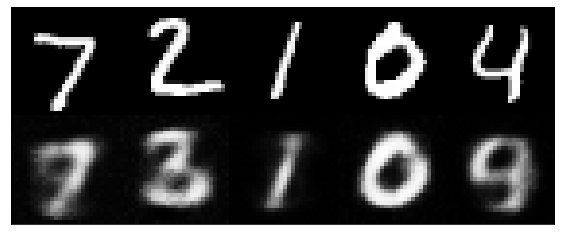

60000/60000 [==============================] - 17s 278us/sample - loss: 0.1576 - val_loss: 0.1025
Epoch 2/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0974

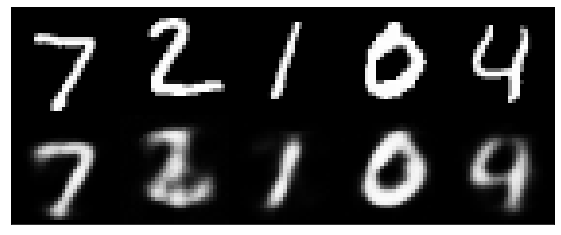

60000/60000 [==============================] - 12s 201us/sample - loss: 0.0973 - val_loss: 0.0873
Epoch 3/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0880

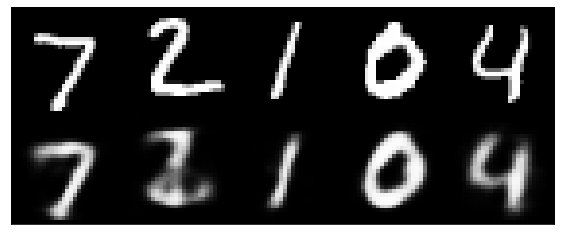

60000/60000 [==============================] - 12s 199us/sample - loss: 0.0880 - val_loss: 0.0824
Epoch 4/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0843

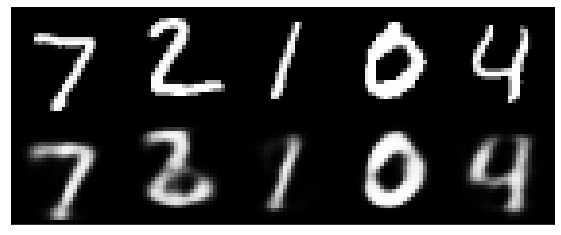

60000/60000 [==============================] - 12s 202us/sample - loss: 0.0843 - val_loss: 0.0798
Epoch 5/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0822

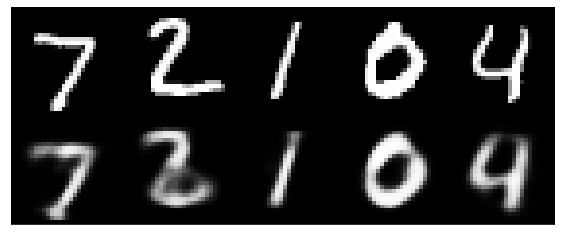

60000/60000 [==============================] - 12s 203us/sample - loss: 0.0822 - val_loss: 0.0780
Epoch 6/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0806

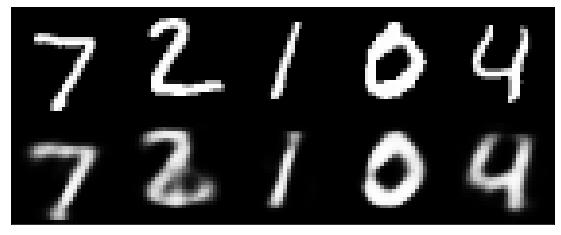

60000/60000 [==============================] - 12s 202us/sample - loss: 0.0805 - val_loss: 0.0766
Epoch 7/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0793

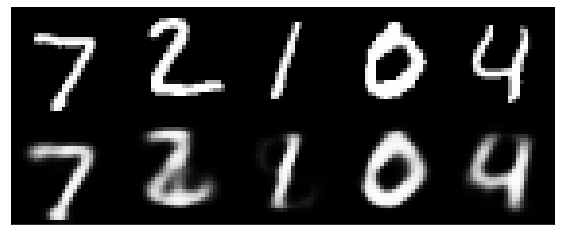

60000/60000 [==============================] - 12s 201us/sample - loss: 0.0793 - val_loss: 0.0757
Epoch 8/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0783

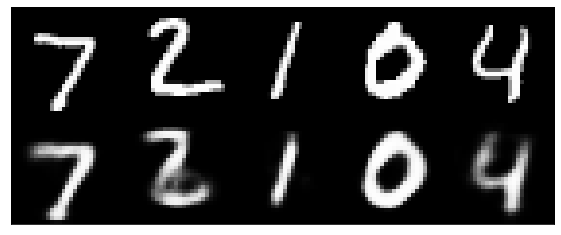

60000/60000 [==============================] - 12s 202us/sample - loss: 0.0783 - val_loss: 0.0747
Epoch 9/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0774

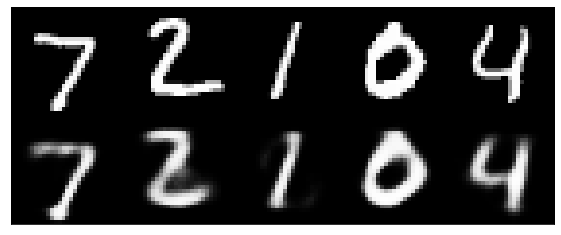

60000/60000 [==============================] - 12s 204us/sample - loss: 0.0775 - val_loss: 0.0739
Epoch 10/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0767

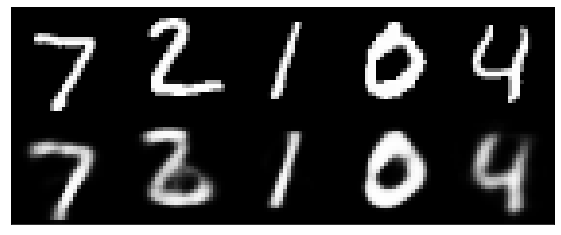

60000/60000 [==============================] - 12s 202us/sample - loss: 0.0767 - val_loss: 0.0733
Epoch 11/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0761

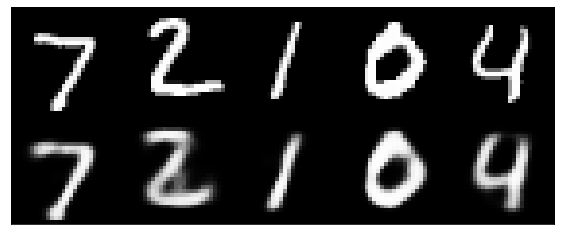

60000/60000 [==============================] - 12s 203us/sample - loss: 0.0761 - val_loss: 0.0726
Epoch 12/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0755

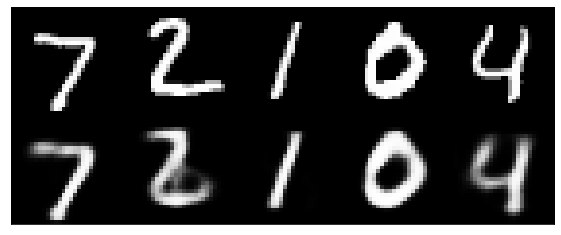

60000/60000 [==============================] - 12s 204us/sample - loss: 0.0755 - val_loss: 0.0721
Epoch 13/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0750

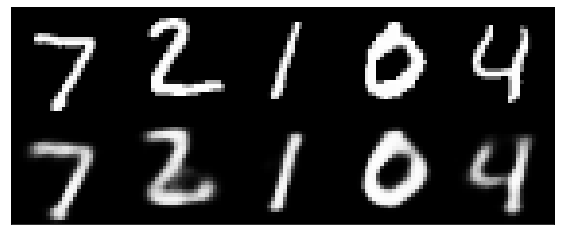

60000/60000 [==============================] - 12s 205us/sample - loss: 0.0750 - val_loss: 0.0715
Epoch 14/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0745

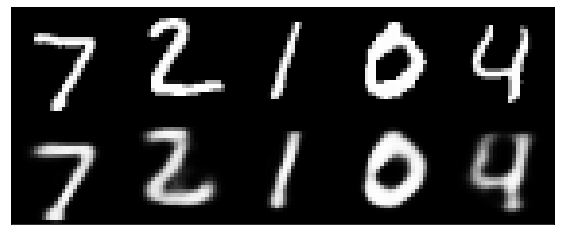

60000/60000 [==============================] - 12s 205us/sample - loss: 0.0745 - val_loss: 0.0711
Epoch 15/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0741

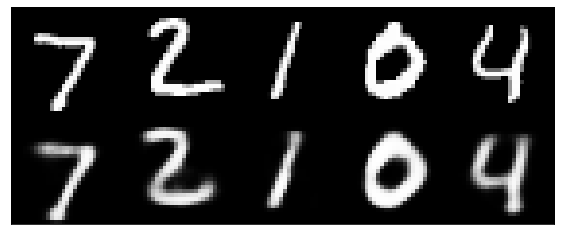

60000/60000 [==============================] - 12s 204us/sample - loss: 0.0741 - val_loss: 0.0708
Epoch 16/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0737

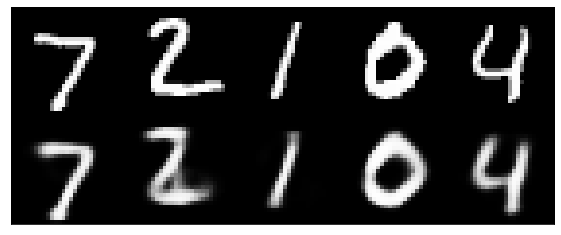

60000/60000 [==============================] - 12s 207us/sample - loss: 0.0737 - val_loss: 0.0704
Epoch 17/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0734

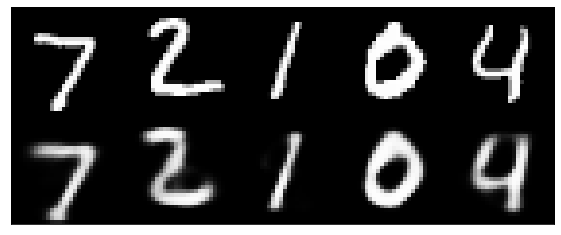

60000/60000 [==============================] - 12s 207us/sample - loss: 0.0734 - val_loss: 0.0701
Epoch 18/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0731

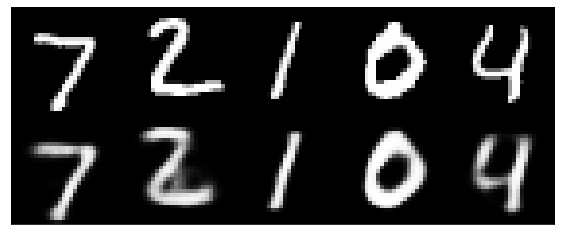

60000/60000 [==============================] - 12s 207us/sample - loss: 0.0731 - val_loss: 0.0698
Epoch 19/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0728

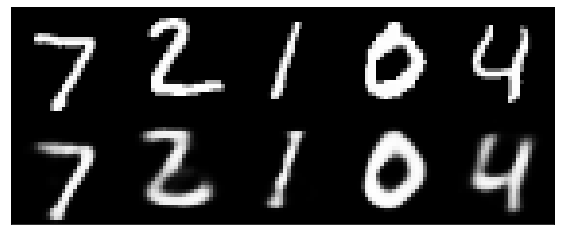

60000/60000 [==============================] - 13s 209us/sample - loss: 0.0728 - val_loss: 0.0696
Epoch 20/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0725

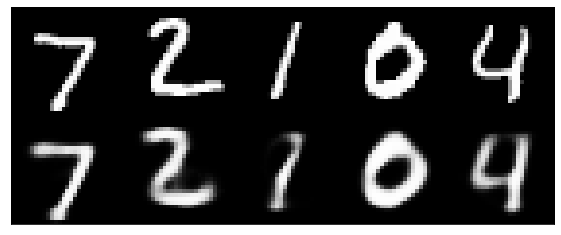

60000/60000 [==============================] - 12s 208us/sample - loss: 0.0725 - val_loss: 0.0693
Epoch 21/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0723

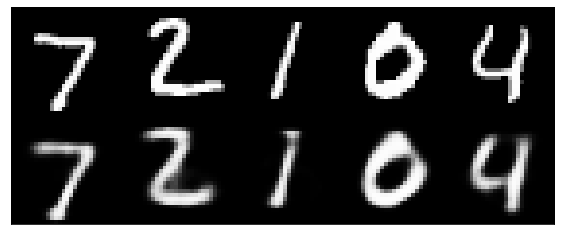

60000/60000 [==============================] - 12s 208us/sample - loss: 0.0723 - val_loss: 0.0690
Epoch 22/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0720

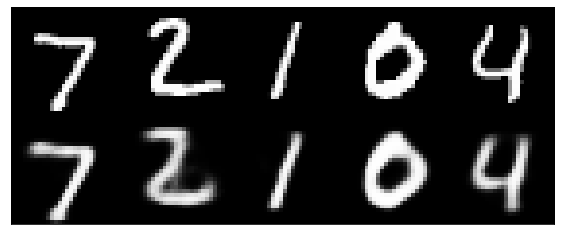

60000/60000 [==============================] - 13s 210us/sample - loss: 0.0720 - val_loss: 0.0688
Epoch 23/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0718

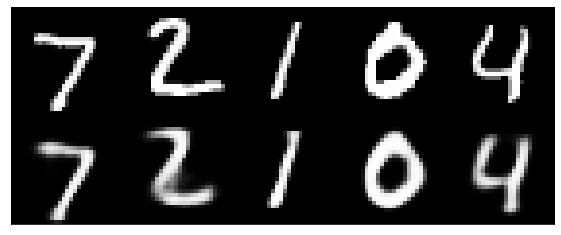

60000/60000 [==============================] - 13s 210us/sample - loss: 0.0718 - val_loss: 0.0685
Epoch 24/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0716

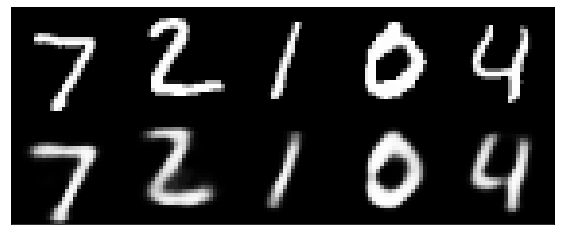

60000/60000 [==============================] - 13s 210us/sample - loss: 0.0716 - val_loss: 0.0684
Epoch 25/25
59500/60000 [============================>.] - ETA: 0s - loss: 0.0714

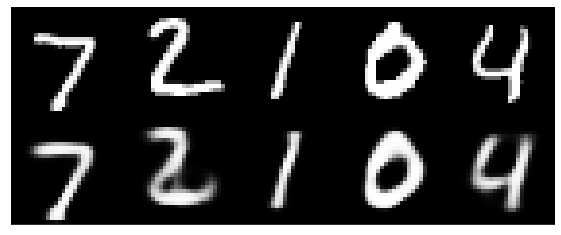

60000/60000 [==============================] - 13s 209us/sample - loss: 0.0714 - val_loss: 0.0683


In [ ]:
# Запуск обучения 
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=25,
         batch_size=batch_size,
         validation_data=([x_test, y_test_cat, y_test_cat], x_test),
         callbacks=[pltfig, tb],
         verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

# Generation



In [ ]:
def style_transfer(model, X, lbl_in, lbl_out): # объявляем функцию переноса стилей
    rows = X.shape[0] 
    if isinstance(lbl_in, int): # заполняем входные лейблы(энкодера)
        lbl = lbl_in 
        lbl_in = np.zeros((rows, 10)) # построчное заполнение нулями от 0 до 9
        lbl_in[:, lbl] = 1 # заполняем в нужную строчку единицу
    if isinstance(lbl_out, int): # заполняем выходные лейблы(декодера)
        lbl = lbl_out
        lbl_out = np.zeros((rows, 10)) # построчное заполнение нулями от 0 до 9
        lbl_out[:, lbl] = 1 # заполняем в нужную строчку единицу
    #print(lbl_in)
    #print(lbl_out)
    return model.predict([X, lbl_in, lbl_out]) # функция вернет предсказанные картинки

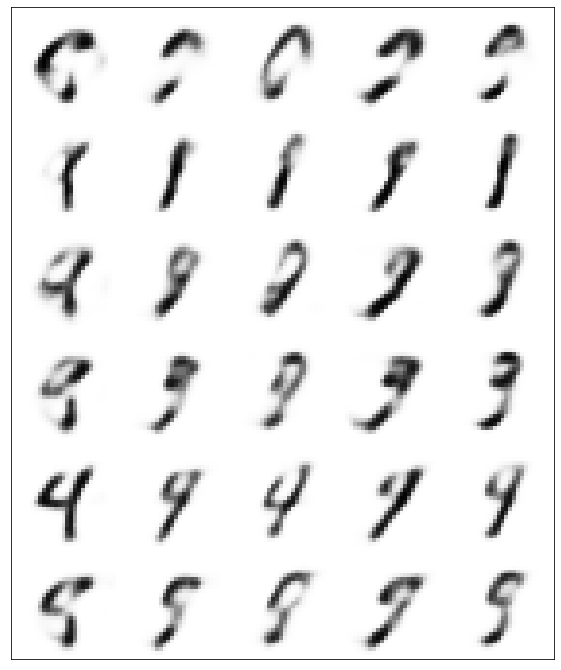

In [ ]:
  n = 5 # выбираем количество картинок
lbl = 9 # выбираем лейбл
generated = [] # здесь соберем список сгенерированных картинок
prot = x_train[y_train == lbl][:n] # возьмем prot в качестве x с соответствующим выбранному значению лейбла 

for i in range(6): # 
    generated.append(style_transfer(models["style_t"], prot, lbl, i)) # и генерим картинки с учетом переноса стиля

#generated[lbl] = prot
plot_digits(*generated, invert_colors=True) # отрисовываем картинки